A simple Bayesian linear regression with Edward and TensorFlow


In [74]:
import numpy as np
import pandas as pd
import edward as ed
import tensorflow as tf

from plot_functions import *

import matplotlib.pyplot as plt
import seaborn as sbn
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [75]:
def generateData(true_intercept=1, true_slope=2, noise=0.5, n_points=20):
    df = pd.DataFrame({'x': np.random.uniform(-2.3, 2.3, size=n_points)})
    df['y'] = true_intercept + true_slope * df['x'] + np.random.np.random.normal(0, scale=noise, size=n_points)
    df = df.sort_values(['x'], ascending=True).reset_index(drop=True)    
    return df

In [76]:
N = 30
D = 1

true_intercept = 1
true_slope = 2

training_df = generateData(true_intercept=true_intercept, true_slope=true_slope, noise=0.5, n_points=N)
X_train = training_df[['x']].values
y_train = training_df['y'].values

In [110]:
X = tf.placeholder(tf.float32, [N, D])
w = ed.models.Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = ed.models.Normal(loc=tf.zeros(1), scale=tf.ones(1))
sigma = 1.0
y = ed.models.Normal(loc=ed.dot(X, w)+b, scale=tf.ones(N)*sigma)

BURN_IN_STEPS = 1000
MCMC_STEPS = 10000
T = BURN_IN_STEPS + MCMC_STEPS

q_w = ed.models.Empirical(params=tf.Variable(tf.zeros([T, D])))
q_b = ed.models.Empirical(params=tf.Variable(tf.zeros([T, 1])))

proposal_w = ed.models.Normal(loc=w, scale=tf.ones(D)*0.3)
proposal_b = ed.models.Normal(loc=b, scale=tf.ones(1)*0.3)

inference = ed.MetropolisHastings(latent_vars={w: q_w, b: q_b}, 
                                  proposal_vars={w: proposal_w, b: proposal_b},
                                  data={X: X_train, y: y_train}) 
inference.run()

11000/11000 [100%] ██████████████████████████████ Elapsed: 15s | Acceptance Rate: 0.309


In [111]:
thin = 10
q_w_trace = q_w.params[BURN_IN_STEPS::thin].eval()[:, 0]
q_b_trace = q_b.params[BURN_IN_STEPS::thin].eval()[:, 0]

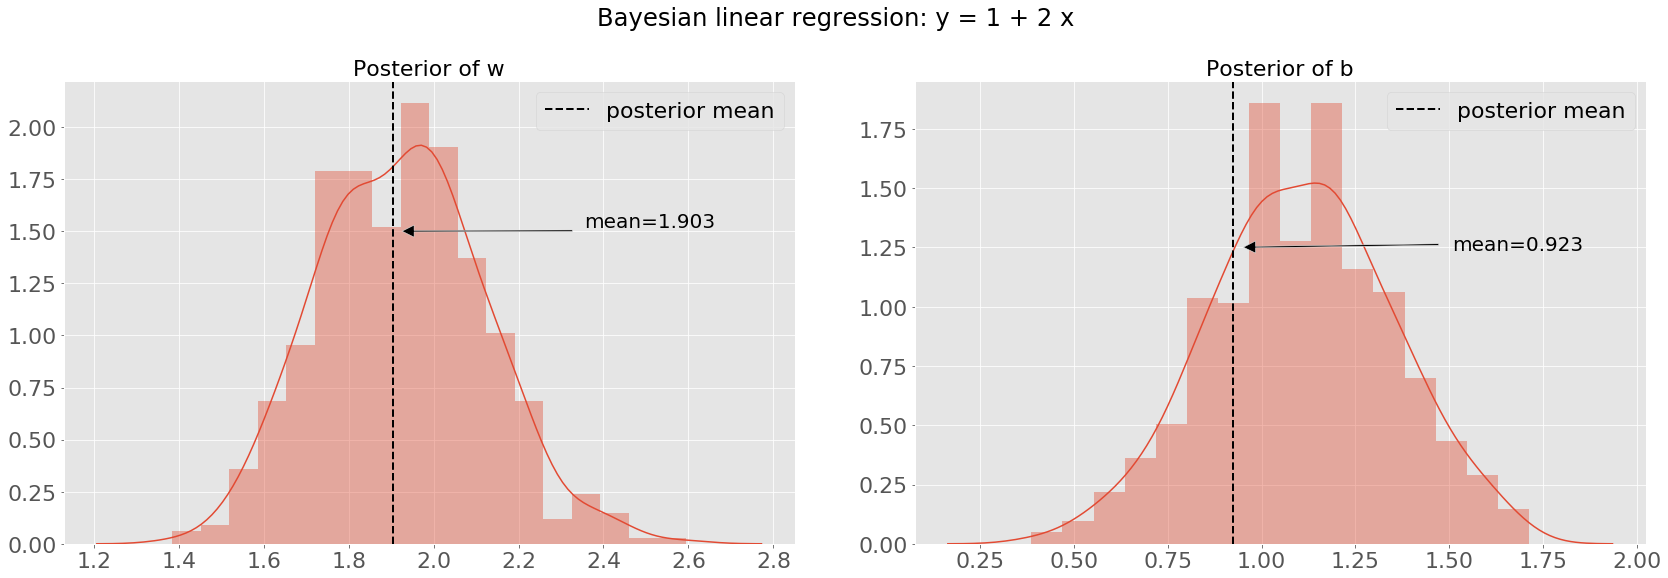

In [112]:
FONTSIZE = 22
plt.close('all')
fig = plt.figure(figsize=(23, 8))   # horizontal, vertical
gs = matplotlib.gridspec.GridSpec(1, 2)  # vertical, horizontal

ax = plt.subplot(gs[0, 0])
ax = sbn.distplot(qw_trace, ax=ax)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
w_mean = q_w_trace.mean()
ax.axvline(w_mean, linestyle='--', linewidth=2, color='k', label='posterior mean')
ax.set_title('Posterior of w', fontsize=FONTSIZE)
ax.legend(loc='best', fontsize=FONTSIZE)
ax.annotate('mean={0:.3f}'.format(w_mean),
            xy=(w_mean, 1.5),
            xytext=(0.35, 0.6),
            textcoords='figure fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
            horizontalalignment='left',
            verticalalignment='bottom',
            fontsize=20)

ax = plt.subplot(gs[0, 1])
ax = sbn.distplot(qb_trace, ax=ax)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
b_mean = q_b_trace.mean()
ax.axvline(b_mean, linestyle='--', linewidth=2, color='k', label='posterior mean')
ax.set_title('Posterior of b', fontsize=FONTSIZE)
ax.legend(loc='best', fontsize=FONTSIZE)
ax.annotate('mean={0:.3f}'.format(b_mean),
            xy=(b_mean, 1.25),
            xytext=(0.87, 0.56),
            textcoords='figure fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
            horizontalalignment='left',
            verticalalignment='bottom',
            fontsize=20)


plt.tight_layout(pad=0, w_pad=6.0, h_pad=5.0)
fig.suptitle('Bayesian linear regression: y = {0:} + {1:} x'.format(true_intercept, true_slope), fontsize=1.1*FONTSIZE)
plt.subplots_adjust(top=0.85)
